In [1]:
import math
import pandas as pd 
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

import h3 # h3 bins from uber

## Loading helper functions

These functions have been copied over from notebooks that already exist for this project. Ideally, these would be imported from a module.

In [2]:
#Loading the data
def create_crash_df(train_file = '../Inputs/Train.csv'):  
    crash_df = pd.read_csv(train_file, parse_dates=['datetime'])
    return crash_df

#Creating temporal features like months, weekdays, etc.
def create_temporal_features(df):
    dict_windows = {1: "00-03", 2: "03-06", 3: "06-09", 4: "09-12", 5: "12-15", 6: "15-18", 7: "18-21", 8: "21-24"}
    dict_months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
               7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
    df["time_window"] = df["datetime"].apply(lambda x: math.floor(x.hour / 3) + 1)
    df["time_window_str"] = df["time_window"].apply(lambda x: dict_windows.get(x))
    df["day"] = df["datetime"].apply(lambda x: x.day)
    df["month"] = df["datetime"].apply(lambda x: dict_months.get(x.month))
    df["year"] = df["datetime"].apply(lambda x: x.year)
    df["weekday"] = df["datetime"].apply(lambda x: x.weekday())
    return df

#Exporting the dataframe back to csv
def export_df_to_csv(df,path_file='../Inputs/train_h3.csv'):
    df.to_csv(path_file,index=False)
    print(f'file created {path_file}') 

#Joins provided data sets for road segments into one file, indicating latitude and longitude for each segment. This enables placement in h3 bins.    
def join_segment_files(path='../Inputs/', road_surveys='Segment_info.csv',segments_geometry='segments_geometry.geojson'):
    ''' 
        Load the survey data, Load the segment geometry, Join the two segment dfs.
        return a combined dataframe
    '''
    road_surveys = pd.read_csv(path+road_surveys)
    road_segment_locs = gpd.read_file(path+segments_geometry)
    segments_merged = pd.merge(road_segment_locs, road_surveys, on='segment_id', how='left')
    segments_merged["longitude"] = segments_merged.geometry.centroid.x
    segments_merged["latitude"] = segments_merged.geometry.centroid.y
    segments_merged = assign_hexbin(segments_merged)
    return segments_merged

#Defines time clusters, see docstring for more info
def assign_TW_cluster(weekday, time_window, holiday=0, strategy='baseline'):
    '''
    Can be used in a lambda function to return the time window cluster for a given day and time window.
    e.g. crash_df["cluster"] = crash_df.apply(lambda x: return_TW_cluster(x.weekday, x.time_window_str) ,axis=1)
    This is called by the function: create_cluster_feature.
    '''
    if strategy == 'baseline':
        return 'baseline'
    
    if strategy == 'mean_shift_modified':
        if weekday == 7:
            return 'off_peak'        
        elif weekday == 6:
            return 'off_peak'
        elif weekday in [0,1,2,3,4]:
            if time_window in ["06-09"]:
                return 'peak'
            elif time_window in ["09-12", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'    
        elif weekday == 5:
            if time_window in ["06-09", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'
            elif time_window in ["09-12"]:
                return 'peak'
    
    elif strategy == 'saturday_2':
        if weekday == 7:
            return 'off_peak'        
        elif weekday == 6:
            return 'off_peak'
        elif weekday in [0,1,2,3,4]:
            if time_window in ["06-09"]:
                return 'peak'
            elif time_window in ["09-12", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'    
        elif weekday == 5:
            if time_window in ["06-09", "12-15", "15-18", "18-21"]:
                return 'saturday_busy'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'
            elif time_window in ["09-12"]:
                return 'saturday_busy'    
    
    elif strategy == 'holiday_7':
        if weekday == 7:
            return 'holiday'        
        elif weekday == 6:
            return 'sunday'
        elif weekday in [0,1,2,3,4]:
            if time_window in ["06-09"]:
                return 'peak'
            elif time_window in ["09-12", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'    
        elif weekday == 5:
            if time_window in ["06-09", "12-15", "15-18", "18-21"]:
                return 'saturday_busy'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'
            elif time_window in ["09-12"]:
                return 'saturday_busy'      

    elif strategy == 'holiday_7':
        if weekday == 7:
            return 'holiday'        
        elif weekday == 6:
            return 'sunday'
        elif weekday in [0,1,2,3,4]:
            if time_window in ["06-09"]:
                return 'peak'
            elif time_window in ["09-12", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'    
        elif weekday == 5:
            if time_window in ["06-09", "12-15", "15-18", "18-21"]:
                return 'saturday_busy'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'
            elif time_window in ["09-12"]:
                return 'saturday_busy'      
    

    elif strategy == 'no_cluster':
        return (str(weekday)+str(time_window)+str(holiday))

#Creates time cluster feature in existing data frame
def create_cluster_feature(crash_df, strategy='baseline', verbose=0):
    '''
    Function takes crash df and creates new column with tw cluster labels.
    If verbose is increased, the time window clusters will be visualised.
    '''
    crash_df["cluster"] = crash_df.apply(lambda x: 
                                         assign_TW_cluster(weekday=x.weekday,
                                                           time_window=x.time_window_str,
                                                           strategy=strategy) 
                                         ,axis=1)
    
    print(f'{crash_df.cluster.nunique()} clusters created')
    if verbose > 1:
        tb_clusters = sns.FacetGrid(crash_df,hue='cluster', height=5)
        tb_clusters.map(sns.stripplot,'weekday', 'time_window_str', s=20, 
                                       order = ['00-03', '03-06', '06-09', '09-12', 
                                                '12-15', '15-18', '18-21', '21-24'],
                                    label = 'Time Window Clusters')
    return crash_df

## Changes to hexbin function

To have a cleaner dataframe for each iteration of the pipeline, I adapted the functioning for creating hex bins so that it takes the desired resolution of the h3 bins is taken as an argument by the function - default is set to 6. The major difference is that the function does not add 3 columns at once now but only the resolution that is specified.

In [3]:
def assign_hexbin(df,lat_column="latitude",lon_column="longitude", hexbin_resolution=6):
    '''Assigning hex bins based on h3 classification and latitude and longitude'''
    df["h3_zone_{}".format(hexbin_resolution)] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], hexbin_resolution),axis=1)
    return df

## Example: How to set up a dataframe for prediction

### Step 1: Set up a data frame and group RTA's according to hex bins and time clusters

In a first step, the data need to be loaded and temporal features are added and hexbin are assigned to locations based on latitude and longitude.

In [4]:
df_raw = create_crash_df()
df = create_temporal_features(df_raw)
df = assign_hexbin(df)
df.head(2)

,uid,datetime,latitude,longitude,time_window,time_window_str,day,month,year,weekday,h3_zone_6
0,1,2018-01-01 00:25:46,-1.188850,36.931382,1,00-03,1,Jan,2018,0,867a6e417ffffff
1,2,2018-01-01 02:02:39,-0.662939,37.208730,1,00-03,1,Jan,2018,0,867a45107ffffff


**Assigning RTA's to time clusters and hex bins**

First this will only be done for the 18 hex bins that we have the data for. The time clusters assumed are defined as follows:
* **peak**: Weekdays from 06-09
* **middle**: Weekdays from 09-21 and Saturday from 06-21
* **off-peak**: All other time windows (every night from 21-06 and the whole Sunday)

Using helper functions to create and assign time cluster features.

In [5]:
df_cluster = create_cluster_feature(df, strategy='mean_shift_modified', verbose=0)

3 clusters created


In [6]:
df_cluster[6:10]

,uid,datetime,latitude,longitude,time_window,time_window_str,day,month,year,weekday,h3_zone_6,cluster
6,7,2018-01-01 05:31:17,-1.165228,36.960008,2,03-06,1,Jan,2018,0,867a6e4a7ffffff,off_peak
7,8,2018-01-01 07:57:56,-1.301303,36.820903,3,06-09,1,Jan,2018,0,867a6e557ffffff,peak
8,9,2018-01-01 09:57:27,-1.134640,36.848220,4,09-12,1,Jan,2018,0,867a6e4f7ffffff,middle
9,10,2018-01-01 10:48:59,-1.117207,37.008278,4,09-12,1,Jan,2018,0,867a6e4b7ffffff,middle


**Helper function for grouping RTA's by hex bin and time cluster**

In [7]:
def rta_per_cluster_and_bins(df_cluster):
    '''Add up RTA's per hex bin and time custer'''
    df_rta = df_cluster.groupby([df_cluster.columns[-2], "cluster"]).agg({"uid": "count"}).reset_index()
    col_names = [df_rta.columns[0]] + [df_rta.columns[1]] + ["RTA"]
    df_rta.columns = col_names
    return df_rta

In [8]:
df_rta = rta_per_cluster_and_bins(df_cluster)
df_rta.head(4)

,h3_zone_6,cluster,RTA
0,867a44a6fffffff,middle,1
1,867a44a6fffffff,off_peak,1
2,867a44b5fffffff,middle,1
3,867a44b5fffffff,peak,1


In [9]:
df_rta[df_rta.columns[0]].nunique()

117

**Note: We would expect there to be 3*117 rows in this example if there were RTA's for each hex bin during each time cluster over the whole data set. The number of 220 rows indicates that there are around 1/3 of hex bin * time cluster combinations for which there has been no RTA.**

In [10]:
df_rta.shape

(220, 3)

Next, we need to create an empty table that contains all hex bins and all time clusters.

**Helper function to get a list of all unique hex bins per unique time cluster**

In [11]:
def get_list_of_h3(df_hex, df_clusters):
    '''Create list of unique hex bins times unique time clusters'''
    return list(set(df_hex[df_hex.columns[0]])) * df_clusters["cluster"].nunique()

Create list of hex bins for empty overall data frame

In [12]:
hex_cluster_comb = get_list_of_h3(df_rta, df_cluster)

**Helper function to get a list that contains the unique time clusters with a length of the unqiue hex bins each**

In [13]:
def get_list_of_states(df_clusters, df_hex):
    '''Create list of time clusters'''
    states = []
    for state in df_clusters["cluster"].unique():
        states += ([state] * df_hex[df_hex.columns[0]].nunique())
    return states

Create list of time clusters for empty data frame

In [14]:
states = get_list_of_states(df_cluster, df_rta)

**Helper function to create empty data frame of format hex bins * time clusters**

In [15]:
def create_empty_df(list_hex_bins, list_time_clusters):
    '''Create an empty data frame of format hex bins * time clusters'''
    df_empty = pd.DataFrame(data=[list_hex_bins, list_time_clusters]).T
    df_empty.columns = [df_rta.columns[0], "cluster"]
    return df_empty

Create empty data frame

In [16]:
df_empty = create_empty_df(hex_cluster_comb, states)

**Next we are gonna "outer" merge the empty table (fill it) with our RTA's per hex bin and time cluster**

In [17]:
def fill_df_hex_rta(df_empty, df_rta):
    '''Join road traffic accidents onto empty data frame'''
    df_merged = pd.merge(df_empty, df_rta, on=[df_empty.columns[0], df_empty.columns[1]], how="outer")
    df_filled = df_merged.fillna(0)
    df_filled = df_filled.sort_values(by=[df_empty.columns[0], df_empty.columns[1]])
    return df_filled

Fill data frame

In [18]:
df_filled = fill_df_hex_rta(df_empty, df_rta)

In [19]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 310 to 160
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   h3_zone_6  351 non-null    object 
 1   cluster    351 non-null    object 
 2   RTA        351 non-null    float64
dtypes: float64(1), object(2)
memory usage: 11.0+ KB


In [20]:
df_filled[10:20]

,h3_zone_6,cluster,RTA
60,867a45077ffffff,off_peak,0.0
177,867a45077ffffff,peak,0.0
315,867a45107ffffff,middle,4.0
81,867a45107ffffff,off_peak,3.0
198,867a45107ffffff,peak,0.0
283,867a4511fffffff,middle,1.0
49,867a4511fffffff,off_peak,0.0
166,867a4511fffffff,peak,0.0
280,867a4512fffffff,middle,1.0
46,867a4512fffffff,off_peak,0.0


### Step 2: Merge and process segment data

All segment data is merged.

In [21]:
segments_merged = join_segment_files()
segments_merged.head(2)

<ipython-input-2-b671da0cbe3a>:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  segments_merged["longitude"] = segments_merged.geometry.centroid.x
<ipython-input-2-b671da0cbe3a>:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  segments_merged["latitude"] = segments_merged.geometry.centroid.y


,segment_id,road_name,geometry,side,25_48,79_76,79_65,79_39,28_78_50,55_90,...,80_97_61_65_16,80_97_61_39_0,80_97_61_39_10,80_97_61_39_11,80_97_61_39_12,80_97_61_39_15,80_97_61_39_16,longitude,latitude,h3_zone_6
0,28_1,accra road-tertiary,"LINESTRING (36.82603 -1.28447, 36.82605 -1.284...",1,1,0,4,4,0.0,5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,36.826302,-1.284096,867a6e42fffffff
1,28_1,accra road-tertiary,"LINESTRING (36.82603 -1.28447, 36.82605 -1.284...",2,1,0,4,4,0.0,5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,36.826302,-1.284096,867a6e42fffffff


**New helper function for dropping irrelevant columns**

In [22]:
def drop_segment_columns(df):
    '''Only columns (features) that are potentially relevant for prediction are kept'''
    df = df.drop(["segment_id", "road_name", "geometry", "side", "longitude", "latitude"], axis=1)
    return df

Dropping irrelevant columns from data frame.

In [23]:
df_segments = drop_segment_columns(segments_merged)
df_segments.head(2)

,25_48,79_76,79_65,79_39,28_78_50,55_90,26_76,92_30,62_51,62_51_27,...,80_97_61_65_12,80_97_61_65_15,80_97_61_65_16,80_97_61_39_0,80_97_61_39_10,80_97_61_39_11,80_97_61_39_12,80_97_61_39_15,80_97_61_39_16,h3_zone_6
0,1,0,4,4,0.0,5,0,3,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,867a6e42fffffff
1,1,0,4,4,0.0,5,0,3,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,867a6e42fffffff


**New helper function for assigning column names to segment data**

In [24]:
def col_names_segments(df):
    '''Rename all columns but keep name of hex bin column'''
    new_names = [i+1 for i in range(len(df.columns) - 1)]
    # Keep the last column named as the respective hex bin resolution
    df.columns = new_names + [df.columns[-1]]
    return df

Renaming columns in segment data frame.

In [25]:
df_segments = col_names_segments(df_segments)
df_segments.head(2)

,1,2,3,4,5,6,7,8,9,10,...,218,219,220,221,222,223,224,225,226,h3_zone_6
0,1,0,4,4,0.0,5,0,3,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,867a6e42fffffff
1,1,0,4,4,0.0,5,0,3,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,867a6e42fffffff


**Helper function for automatically identifying the type of a feature**

1. we will attempt to identify all columns with categorical information. These should only contain the values 0 or 1. 
2. Second, we will identify those columns that hold percentage data. The assumption is that they only contain values between 0 and 1 but unlike categorical columns, also have other values than 0 and 1.
3. Last, we classsify all remaining columns as holding count data.

In [26]:
def col_type_identifier(df):
    '''Assigns columns to either be of type boolean, percentage or count and returns a list with the column indices for each type'''
    list_boolean = []
    list_percentages = []
    list_counts = []
    hexbins = [df.columns[-1]]
    for col in df.columns:
        if (df[col].max() == 1) and (df[col].min() == 0):
            if df[col].sum() % 1 == 0:
                list_boolean.append(col)
            else:
                list_percentages.append(col)
        elif df[col].dtype == "object":
            break
        else:
            list_counts.append(col)
    #Need to add the last column to the lists to keep the hex bins in each sub data frame
    return list_boolean + hexbins, list_counts + hexbins, list_percentages + hexbins

Sorting columns into different types and receiving three lists with the corresponding columns indices

In [27]:
booleans, counts, percentages = col_type_identifier(df_segments)

**Helper function aggregating the column values over the defined h3 bins according to their type (boolean, count or percentage)**

In [28]:
def df_split_types(df, booleans, counts, percentages, count_agg_type=np.sum, bool_agg_type=np.sum, perc_agg_type=np.mean):
    '''Splits overall data frame into data frames of different types and uses specified aggregration function for each of them'''
    df_bools = df.loc[:,booleans]
    df_count = df.loc[:,counts]
    df_perc = df.loc[:,percentages]
    
    hexbins = df.columns[-1]

    df_count_grouped = df_count.groupby(hexbins).agg(count_agg_type).reset_index()
    df_bool_grouped = df_bools.groupby(hexbins).agg(bool_agg_type).reset_index()
    #Currently commented out because contains no values for our input data
    #df_perc_grouped = df_perc.groupby(hexbins).agg(perc_agg_type).reset_index()
    
    return df_count_grouped, df_bool_grouped # df_perc_grouped 

In [29]:
df_counts, df_bools = df_split_types(df_segments, booleans, counts, percentages)

In [30]:
df_counts.head(2)

,h3_zone_6,1,3,4,6,8,9,10,11,12,...,41,42,43,44,45,46,50,51,52,53
0,867a6e407ffffff,174,319,319,756,274,234,113,205,125,...,76.0,612,434,401,0.0,0.0,467,83.0,180.0,169.0
1,867a6e40fffffff,18,13,13,66,13,6,6,12,6,...,6.0,36,24,24,0.0,0.0,40,10.0,18.0,8.0


In [31]:
df_counts.shape

(18, 38)

In [32]:
df_bools.head(2)

,h3_zone_6,2,5,7,19,23,24,25,27,29,...,217,218,219,220,221,222,223,224,225,226
0,867a6e407ffffff,0,30.0,0,89,2,0.0,41,5.0,0,...,5.0,61.0,2.0,3.0,1.0,0.0,3.0,60.0,2.0,3.0
1,867a6e40fffffff,0,0.0,0,3,0,0.0,0,0.0,0,...,4.0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0


In [33]:
df_bools.shape

(18, 190)

Both the boolean and the count data frames have been grouped to 18 rows, corresponding to the number of hex bins in the segment data given the default resolution.

**Helper function to merge the data frames for the different data types together**

In [34]:
def df_merge_types(df1, df2):
    '''Merging the data frames of different types back together and sorting the features'''
    df = pd.merge(df1, df2, on=df1.columns[0], how='left')
    df = df.reindex([df.columns[0]] + sorted(df.columns[1:]), axis=1)
    return df

In [35]:
df_grouped = df_merge_types(df_counts, df_bools)
print(df_grouped.shape)
df_grouped.head(2)

(18, 227)


,h3_zone_6,1,2,3,4,5,6,7,8,9,...,217,218,219,220,221,222,223,224,225,226
0,867a6e407ffffff,174,0,319,319,30.0,756,0,274,234,...,5.0,61.0,2.0,3.0,1.0,0.0,3.0,60.0,2.0,3.0
1,867a6e40fffffff,18,0,13,13,0.0,66,0,13,6,...,4.0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0


***

### Step 3: Filter RTA table for hex bins that are in the segment data

Next we will filter for only those hex bins that we have segment data for (file provided by Zindi) - in this case (given a hex bin resolution of 6) that means we will keep 18 out of 117 hex bins.

In [36]:
reduced_hex_bins = list(df_grouped[df_grouped.columns[0]])

In [37]:
def reduced_df(df_filled, reduced_hex_bins):
    '''Filter filled data frame for hex bins present in segment data'''
    df_reduced = df_filled[df_filled[df_filled.columns[0]].isin(reduced_hex_bins)]
    df_sorted = df_reduced.sort_values(by=[df_filled.columns[0], df_filled.columns[1]])
    return df_sorted

In [38]:
df_reduced = reduced_df(df_filled, reduced_hex_bins)

In [39]:
df_reduced.head()

,h3_zone_6,cluster,RTA
249,867a6e407ffffff,middle,329.0
15,867a6e407ffffff,off_peak,138.0
132,867a6e407ffffff,peak,227.0
268,867a6e40fffffff,middle,48.0
34,867a6e40fffffff,off_peak,27.0


Need to still normalize the amount of RTA per hex bin and time cluster by the amount of 3-hour time window per time cluster

**Note: Still need to make this into a function somehow**

In [40]:
list_of_clusters = ["middle", "off_peak", "peak"]

In [41]:
peak = 5 * 1
off_peak = 6 * 3 + 8
middle = 6 * 4 + 1

In [42]:
cluster_dict = {"middle": middle, "off_peak": off_peak, "peak": peak}

**Normalizing RTA's for number of time windows**

In [43]:
def normalize_rta(df, list_of_clusters, cluster_dict):
    '''Divide RTAs per hex bin by amount of time windows (3 hour) of the related time cluster''' 
    for cluster in list_of_clusters:
        df.loc[df["cluster"] == cluster, "RTA_h"] = cluster_dict.get(cluster)
        df["RTA_n"] = df["RTA"] / df["RTA_h"]
    return df

In [44]:
df_normalized = normalize_rta(df_reduced, list_of_clusters, cluster_dict)

In [45]:
df_normalized = df_normalized.drop(["RTA", "RTA_h"], axis=1)

In [46]:
df_normalized.head()

,h3_zone_6,cluster,RTA_n
249,867a6e407ffffff,middle,13.160000
15,867a6e407ffffff,off_peak,5.307692
132,867a6e407ffffff,peak,45.400000
268,867a6e40fffffff,middle,1.920000
34,867a6e40fffffff,off_peak,1.038462


### Step 4: Add features to the RTA table

As a last step, we have to add the desired features to the table, in this case the segment data from the segment data frame

In [47]:
def join_features_on_df(df_base, df_features):
    '''Join features onto the empty table'''
    df = pd.merge(df_base, df_features, on=df_base.columns[0], how="left")
    return df

In [48]:
df_regr = join_features_on_df(df_normalized, df_grouped)

In [49]:
df_regr.head()

,h3_zone_6,cluster,RTA_n,1,2,3,4,5,6,7,...,217,218,219,220,221,222,223,224,225,226
0,867a6e407ffffff,middle,13.160000,174,0,319,319,30.0,756,0,...,5.0,61.0,2.0,3.0,1.0,0.0,3.0,60.0,2.0,3.0
1,867a6e407ffffff,off_peak,5.307692,174,0,319,319,30.0,756,0,...,5.0,61.0,2.0,3.0,1.0,0.0,3.0,60.0,2.0,3.0
2,867a6e407ffffff,peak,45.400000,174,0,319,319,30.0,756,0,...,5.0,61.0,2.0,3.0,1.0,0.0,3.0,60.0,2.0,3.0
3,867a6e40fffffff,middle,1.920000,18,0,13,13,0.0,66,0,...,4.0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0
4,867a6e40fffffff,off_peak,1.038462,18,0,13,13,0.0,66,0,...,4.0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0


In [50]:
df_regr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 0 to 53
Columns: 229 entries, h3_zone_6 to 226
dtypes: float64(28), int64(199), object(2)
memory usage: 97.0+ KB


## Prediction

This analysis was done following the "Dimensionality_Reduction" module and more precisely, the notebook "1-Principal_Component_Analysis".

### Step 1: Data Scaling

In [51]:
from sklearn.preprocessing import StandardScaler

In [52]:
scaler = StandardScaler()

In [53]:
list_non_numeric = [df_regr.columns[0]] + [df_regr.columns[1]] + [df_regr.columns[2]]

In [54]:
X_num = df_regr.drop(list_non_numeric, axis=1)
X_cat = df_regr[df_regr.columns[1]]
y = df_regr[df_regr.columns[2]]

In [55]:
X_num_t = scaler.fit_transform(X_num)

In [56]:
df_regr_scaled = pd.DataFrame(data=X_num_t,columns=X_num.columns)

In [57]:
df_regr_scaled.head(1)

,1,2,3,4,5,6,7,8,9,10,...,217,218,219,220,221,222,223,224,225,226
0,0.066956,-0.628539,0.074491,0.069021,2.550458,0.02085,-0.380143,0.18766,0.257468,0.119111,...,-0.517076,0.338516,-0.364625,-0.023939,-0.412027,-0.321029,-0.608984,0.331693,-0.364929,0.0


In [58]:
df_regr_scaled.describe().round()

,1,2,3,4,5,6,7,8,9,10,...,217,218,219,220,221,222,223,224,225,226
count,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,...,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0
mean,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,...,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-0.0,-0.0,-1.0,-1.0,-1.0,-1.0
25%,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-0.0,-0.0,-1.0,-1.0,-1.0,-1.0
50%,-0.0,-1.0,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0
75%,0.0,1.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
max,4.0,3.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,...,3.0,4.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0


### Step 2: PCA

In [59]:
from sklearn.decomposition import PCA

In [60]:
pca = PCA(n_components=0.9)

In [61]:
df_scaled_pca = pca.fit(df_regr_scaled)

**Plotting**

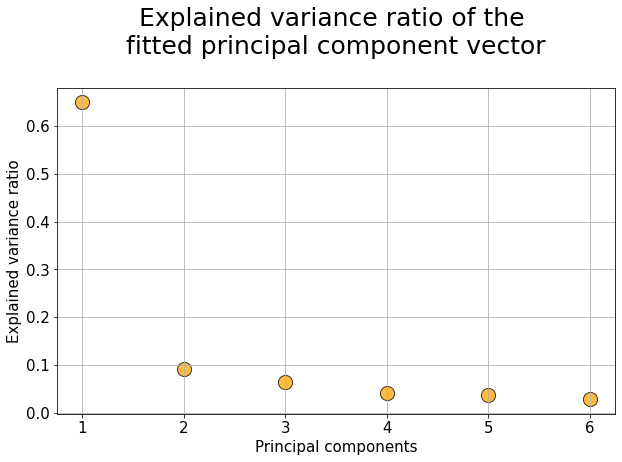

In [62]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(df_scaled_pca.explained_variance_ratio_))],
            y=df_scaled_pca.explained_variance_ratio_,
            s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_scaled_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.savefig("PCA.png")
plt.show()

End.

In [63]:
i = 1
for pca_component in df_scaled_pca.explained_variance_ratio_:
    if pca_component > 0.01:
        print("Component", i, "explains", round(pca_component * 100, 2), "%")
        i += 1

Component 1 explains 64.91 %
Component 2 explains 9.21 %
Component 3 explains 6.44 %
Component 4 explains 4.14 %
Component 5 explains 3.77 %
Component 6 explains 2.92 %


In [64]:
df_regr_pca = pca.transform(df_regr_scaled)

In [65]:
df_regr_pca[0:2]

array([[ 1.99457019,  4.30522952, 14.37359213, -2.17309472,  0.63737403,
        -1.37359127],
       [ 1.99457019,  4.30522952, 14.37359213, -2.17309472,  0.63737403,
        -1.37359127]])

In [66]:
df_regr_pca.shape

(54, 6)

***

### Step 3: Regression

### To Do:
**Paste together with categorical data to build data set for prediction**

In [67]:
df_regression = pd.DataFrame(df_regr_pca, columns=["PCA_1", "PCA_2", "PCA_3", "PCA_4", "PCA_5", "PCA_6"])

In [68]:
time_cluster_dummies = pd.get_dummies(df_regr['cluster'], prefix='cluster', drop_first=True)

I am not sure whether we should or should not drop one column for the dummies?

In [69]:
df_regression = pd.concat([df_regression, time_cluster_dummies], axis = 1)

In [70]:
df_regression.head(1)

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,cluster_off_peak,cluster_peak
0,1.99457,4.30523,14.373592,-2.173095,0.637374,-1.373591,0,0


### Linear Regression

In [71]:
from sklearn.linear_model import LinearRegression

In [72]:
X = df_regression

In [73]:
reg = LinearRegression().fit(X, y)

In [74]:
reg.score(X, y)

0.6596955866610159

In [75]:
reg.coef_

array([ 0.49269668, -0.24820024,  0.9383647 ,  0.30828919,  0.52471648,
       -0.29208551, -2.81401709, 10.80222222])

In [76]:
reg.intercept_

5.553333333333332

### Ridge Regression

In [77]:
from sklearn.linear_model import Ridge

In [78]:
ridge_reg = Ridge(alpha=0.5)

In [79]:
ridge_reg.fit(X, y)

Ridge(alpha=0.5)

In [80]:
ridge_reg.score(X, y)

0.6593671159314402

### SVR

In [81]:
from sklearn.svm import SVR

In [82]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_sigmoid = SVR(kernel='sigmoid', C=100, gamma="auto", epsilon=.1, coef0=1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

In [83]:
print(svr_rbf.fit(X, y))
print(svr_lin.fit(X, y))
print(svr_poly.fit(X, y))
print(svr_sigmoid.fit(X, y))

SVR(C=100, gamma=0.1)
SVR(C=100, gamma='auto', kernel='linear')
SVR(C=100, coef0=1, gamma='auto', kernel='poly')
SVR(C=100, coef0=1, gamma='auto', kernel='sigmoid')


In [84]:
print("RBF:", svr_rbf.score(X, y))
print("Lin:", svr_lin.score(X, y))
print("Poly", svr_poly.score(X, y))
print("Sigmoid", svr_sigmoid.score(X, y))

RBF: 0.9351216493214036
Lin: 0.6120579810480937
Poly 0.997251594446552
Sigmoid -4941.285496492263


***

In [85]:
X.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,cluster_off_peak,cluster_peak
0,1.994570,4.30523,14.373592,-2.173095,0.637374,-1.373591,0,0
1,1.994570,4.30523,14.373592,-2.173095,0.637374,-1.373591,1,0
2,1.994570,4.30523,14.373592,-2.173095,0.637374,-1.373591,0,1
3,-7.233945,-0.76182,0.551347,0.014599,-1.663399,0.473769,0,0
4,-7.233945,-0.76182,0.551347,0.014599,-1.663399,0.473769,1,0


In [86]:
pred_y = svr_poly.predict(X)

In [87]:
input_preds = {"Predictions": pred_y, "Real_values": y}

In [88]:
df_y_vs_pred = pd.DataFrame(data=input_preds)

In [89]:
df_y_vs_pred["Error"] = df_y_vs_pred["Predictions"] - df_y_vs_pred["Real_values"]

In [90]:
df_y_vs_pred.head()

,Predictions,Real_values,Error
0,13.260166,13.160000,0.100166
1,5.408049,5.307692,0.100357
2,45.299958,45.400000,-0.100042
3,1.820692,1.920000,-0.099308
4,1.135168,1.038462,0.096706


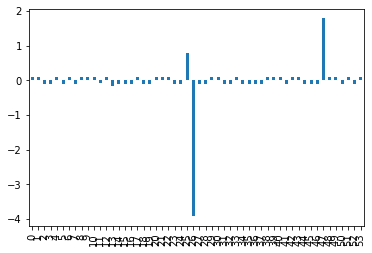

In [91]:
df_y_vs_pred["Error"].plot(kind="bar");

In [92]:
X.describe()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,cluster_off_peak,cluster_peak
count,5.400000e+01,5.400000e+01,5.400000e+01,5.400000e+01,5.400000e+01,5.400000e+01,54.000000,54.000000
mean,9.539694e-16,-4.111937e-17,1.644775e-16,-5.345518e-17,3.289550e-17,2.981154e-17,0.333333,0.333333
std,1.217155e+01,4.585337e+00,3.834450e+00,3.073884e+00,2.931605e+00,2.583278e+00,0.475831,0.475831
min,-8.094284e+00,-8.935825e+00,-4.406919e+00,-5.010693e+00,-2.699515e+00,-4.005105e+00,0.000000,0.000000
25%,-7.189131e+00,-1.378707e+00,-1.627780e+00,-8.930322e-01,-1.981440e+00,-1.059751e+00,0.000000,0.000000
50%,-3.207493e+00,-7.627021e-01,-9.084637e-01,-4.081424e-01,-9.011106e-01,-1.870204e-01,0.000000,0.000000
75%,8.511226e-01,1.093745e-01,3.074724e-01,9.947620e-02,6.373740e-01,4.737692e-01,1.000000,1.000000
max,4.250169e+01,1.583140e+01,1.437359e+01,1.139091e+01,9.528100e+00,9.311353e+00,1.000000,1.000000


### Mean Approach

In [93]:
proxy_other_segments = [[0,0,0,0,0,0,0,1], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,0]]

In [94]:
pred_proxy = svr_poly.predict(proxy_other_segments)

In [95]:
pred_proxy

array([20.25647582,  8.00232564,  9.64088148])

In [96]:
names_proxy = ["peak", "off_peak", "middle"]

In [97]:
df_proxies = pd.DataFrame(proxy_other_segments, columns=X.columns)

In [98]:
df_proxies["cluster"] = names_proxy
df_proxies["Pred_value"] = pred_proxy

In [99]:
df_proxies.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,cluster_off_peak,cluster_peak,cluster,Pred_value
0,0,0,0,0,0,0,0,1,peak,20.256476
1,0,0,0,0,0,0,1,0,off_peak,8.002326
2,0,0,0,0,0,0,0,0,middle,9.640881


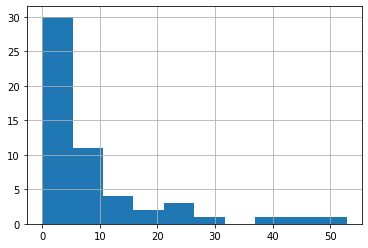

In [100]:
y.hist();

### Median Approach

In [101]:
medians = [X.PCA_1.median(), X.PCA_2.median(), X.PCA_3.median(), X.PCA_4.median(), X.PCA_5.median(), X.PCA_6.median()]

In [102]:
peak_pred_med = medians + [0, 1]
off_peak_pred_med = medians + [1, 0]
middle_pred_med = medians + [0, 0]

In [103]:
df_proxies_med = pd.DataFrame([peak_pred_med, off_peak_pred_med, middle_pred_med], columns=X.columns)

In [104]:
pred_proxy_med = svr_poly.predict([peak_pred_med, off_peak_pred_med, middle_pred_med])

In [105]:
df_proxies_med["cluster"] = names_proxy
df_proxies_med["Pred_value"] = pred_proxy_med

In [106]:
df_proxies_med.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,cluster_off_peak,cluster_peak,cluster,Pred_value
0,-3.207493,-0.762702,-0.908464,-0.408142,-0.901111,-0.18702,0,1,peak,11.039060
1,-3.207493,-0.762702,-0.908464,-0.408142,-0.901111,-0.18702,1,0,off_peak,-0.135862
2,-3.207493,-0.762702,-0.908464,-0.408142,-0.901111,-0.18702,0,0,middle,1.291591


**How is the weight of our 18 hex bins comapred to overall accidents?**

In [107]:
print("18 hex bins", df_reduced.RTA.sum())
print("117 hex bins", df_filled.RTA.sum())

18 hex bins 5253.0
117 hex bins 6318.0


In [108]:
print("Accidents still to explain", df_filled.RTA.sum() - df_reduced.RTA.sum())

Accidents still to explain 1065.0


**Allocate RTA's to "outer" hex bins and over time? Different strategies!**

In [109]:
(df_filled.RTA.sum() - df_reduced.RTA.sum()) / 99

10.757575757575758

***

## Setting up overall input with 3 hour time windows for regression

In order to have an input template for the regression, we need to format data into 3-hours time windows. This is required because the goal is to predict RTA's per time windowd (and hex bin).

In [110]:
def create_raw_pred_input_df(df_hex_bins):
    '''Based on hex bin resolution creates an empty data frame for each 3 hour time window for each hex bin.
     This results in a n * 2 dataframe (columns: time_windows, hex_bins) where number of rows equals hex_bins * 4369.
     4369 is the result of days between start and end date (in days) * 8 time windows per day (24 / 3 hours)'''
    #Create dataframe to get the accurate amount of 3-hour time windows for the desired time frame
    date_start = '2018-01-01'
    date_end = '2019-07-01'
    dates = pd.date_range(date_start, date_end, freq='3h')
    all_days_df = pd.DataFrame(dates, columns=["dates"])

    time_windows = list(all_days_df["dates"])
    len_windows = all_days_df.shape[0]
    list_unique_hexbins = df_hex_bins[df_hex_bins.columns[0]].unique()
    
    list_bins_per_window = []
    list_time_windows = []
    
    for i in range(0, len(list_unique_hexbins)):
        list_bins_per_window += len_windows * [list_unique_hexbins[i]]
        list_time_windows += time_windows
        
    input_df = {"time_windows": list_time_windows, "hex_bins": list_bins_per_window}
    df_pred_template = pd.DataFrame(data=input_df)
    
    return df_pred_template

In [111]:
df_raw_pred = create_raw_pred_input_df(df_filled)

In [112]:
df_raw_pred.shape

(511173, 2)

This is the resulting data frame for 117 hex bins - for different hx bin resolutions, use the corresponding hex bin data frame as input.

**Add RTA's**

In [113]:
df_raw_pred.head()

,time_windows,hex_bins
0,2018-01-01 00:00:00,867a44a6fffffff
1,2018-01-01 03:00:00,867a44a6fffffff
2,2018-01-01 06:00:00,867a44a6fffffff
3,2018-01-01 09:00:00,867a44a6fffffff
4,2018-01-01 12:00:00,867a44a6fffffff


Need to first create a key (field) over which we can aggregate the time windows

In [114]:
df_raw_pred["time_window_key"] = df_raw_pred["time_windows"].apply(lambda x: str(x.year) + "-" + str(x.month) + "-" + str(x.day) + "-" + str(math.floor(x.hour / 3)))

In [115]:
df_raw_pred.head()

,time_windows,hex_bins,time_window_key
0,2018-01-01 00:00:00,867a44a6fffffff,2018-1-1-0
1,2018-01-01 03:00:00,867a44a6fffffff,2018-1-1-1
2,2018-01-01 06:00:00,867a44a6fffffff,2018-1-1-2
3,2018-01-01 09:00:00,867a44a6fffffff,2018-1-1-3
4,2018-01-01 12:00:00,867a44a6fffffff,2018-1-1-4


**New helper function for aggregating RTA's over 3-hour time windows (not yet to hex bins)**

In [116]:
df_cluster["time_window_key"] = df_cluster["datetime"].apply(lambda x: str(x.year) + "-" + str(x.month) + "-" + str(x.day) + "-" + str(math.floor(x.hour / 3)))

In [117]:
df_cluster.head()

,uid,datetime,latitude,longitude,time_window,time_window_str,day,month,year,weekday,h3_zone_6,cluster,time_window_key
0,1,2018-01-01 00:25:46,-1.188850,36.931382,1,00-03,1,Jan,2018,0,867a6e417ffffff,off_peak,2018-1-1-0
1,2,2018-01-01 02:02:39,-0.662939,37.208730,1,00-03,1,Jan,2018,0,867a45107ffffff,off_peak,2018-1-1-0
2,3,2018-01-01 02:31:49,-0.662939,37.208730,1,00-03,1,Jan,2018,0,867a45107ffffff,off_peak,2018-1-1-0
3,4,2018-01-01 03:04:01,-1.288087,36.826583,2,03-06,1,Jan,2018,0,867a6e42fffffff,off_peak,2018-1-1-1
4,5,2018-01-01 03:58:49,-1.188850,36.931382,2,03-06,1,Jan,2018,0,867a6e417ffffff,off_peak,2018-1-1-1


This was too early - need to get the hex bins in there as well. We want the hex bins AND time windows (unique) and then join onto that the RTA's per hex bin and time windows (unqiue). df_raw_pred is the empty template and df_cluster is what we will joint onto it.

In [118]:
def rta_per_time_window(df_cluster):
    '''Add up RTA's per time window'''
    df_tw = df_cluster.groupby(["time_window_key", "h3_zone_6"]).agg({"uid": "count"}).reset_index()
    col_names = ["time_window_key"] + ["hex_bins"] + ["RTA"]
    df_tw.columns = col_names
    return df_tw

In [119]:
df_tw = rta_per_time_window(df_cluster)

In [120]:
df_tw.head()

,time_window_key,hex_bins,RTA
0,2018-1-1-0,867a45107ffffff,2
1,2018-1-1-0,867a6e417ffffff,1
2,2018-1-1-1,867a45107ffffff,1
3,2018-1-1-1,867a6e417ffffff,1
4,2018-1-1-1,867a6e42fffffff,1


In [121]:
df_tw.RTA.max()

39

In [122]:
df_tw[df_tw.RTA > 1].shape

(1014, 3)

There are 47 out of the overall 117 hex bins that have at least one time more than one accident in a single time window. this could be one (meta) class. Might have to differentiate even further.

In [123]:
df_tw[df_tw.RTA > 1].hex_bins.nunique()

47

In [124]:
df_tw.shape

(4272, 3)

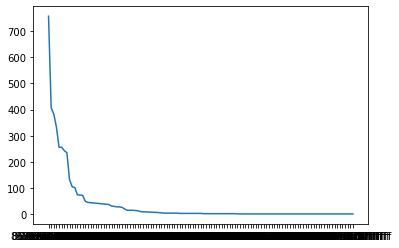

In [125]:
plt.plot(df_tw.groupby("hex_bins").time_window_key.count().sort_values(ascending=False))

In [126]:
df_tw_high = df_tw.loc[df_tw["RTA"] > 5]

In [127]:
df_tw_high.sort_values(by="time_window_key", ascending=True).head(20)

,time_window_key,hex_bins,RTA
88,2018-1-2-2,867a6e477ffffff,8
116,2018-1-22-0,867a6e42fffffff,6
145,2018-1-25-0,867a6e417ffffff,15
172,2018-1-28-2,867a6e4a7ffffff,6
176,2018-1-29-0,867a6e557ffffff,14
184,2018-1-3-0,867a6e42fffffff,6
186,2018-1-3-1,867a6e42fffffff,7
188,2018-1-3-1,867a6e50fffffff,6
229,2018-1-5-2,867a6e407ffffff,6
246,2018-1-7-3,867a6e477ffffff,15


**Next -> (outer) join df_tw onto df_raw_pred**

This creates the sparse event matrix for all time windows and hex bins.

In [128]:
df_tw.shape

(4272, 3)

In [129]:
df_tw.head(10)

,time_window_key,hex_bins,RTA
0,2018-1-1-0,867a45107ffffff,2
1,2018-1-1-0,867a6e417ffffff,1
2,2018-1-1-1,867a45107ffffff,1
3,2018-1-1-1,867a6e417ffffff,1
4,2018-1-1-1,867a6e42fffffff,1
5,2018-1-1-1,867a6e4a7ffffff,1
6,2018-1-1-2,867a6e557ffffff,1
7,2018-1-1-3,867a6e42fffffff,2
8,2018-1-1-3,867a6e4b7ffffff,1
9,2018-1-1-3,867a6e4f7ffffff,1


In [130]:
df_raw_pred.shape

(511173, 3)

In [131]:
#df_raw_pred.drop("time_windows", axis=1, inplace=True)

In [132]:
df_raw_pred.head(10)

,time_windows,hex_bins,time_window_key
0,2018-01-01 00:00:00,867a44a6fffffff,2018-1-1-0
1,2018-01-01 03:00:00,867a44a6fffffff,2018-1-1-1
2,2018-01-01 06:00:00,867a44a6fffffff,2018-1-1-2
3,2018-01-01 09:00:00,867a44a6fffffff,2018-1-1-3
4,2018-01-01 12:00:00,867a44a6fffffff,2018-1-1-4
5,2018-01-01 15:00:00,867a44a6fffffff,2018-1-1-5
6,2018-01-01 18:00:00,867a44a6fffffff,2018-1-1-6
7,2018-01-01 21:00:00,867a44a6fffffff,2018-1-1-7
8,2018-01-02 00:00:00,867a44a6fffffff,2018-1-2-0
9,2018-01-02 03:00:00,867a44a6fffffff,2018-1-2-1


In [133]:
def fill_overall_df(df_raw_pred, df_rta_per_tw):
    '''Join road traffic accidents onto empty data frame that consists of time windows (8 per day) for all days (1.5 years) for all hex bins. 
    For combinations with no accidents, NaNs will be converted into 0.'''
    df_merged = pd.merge(df_raw_pred, df_rta_per_tw, on=["time_window_key", "hex_bins"], how="outer")
    df_merged = df_merged.fillna(0)
    return df_merged

In [134]:
df_raw_filled = fill_overall_df(df_raw_pred, df_tw)

In [135]:
df_raw_filled.head()

,time_windows,hex_bins,time_window_key,RTA
0,2018-01-01 00:00:00,867a44a6fffffff,2018-1-1-0,0.0
1,2018-01-01 03:00:00,867a44a6fffffff,2018-1-1-1,0.0
2,2018-01-01 06:00:00,867a44a6fffffff,2018-1-1-2,0.0
3,2018-01-01 09:00:00,867a44a6fffffff,2018-1-1-3,0.0
4,2018-01-01 12:00:00,867a44a6fffffff,2018-1-1-4,0.0


In [136]:
df_raw_filled.shape

(511173, 4)

In [137]:
df_raw_filled[df_raw_filled.RTA > 0].shape

(4272, 4)

In [138]:
df_raw_filled.groupby("hex_bins").RTA.sum().sort_values(ascending=False).head(10)

hex_bins
867a6e42fffffff    1104.0
867a6e407ffffff     694.0
867a6e557ffffff     652.0
867a6e50fffffff     535.0
867a6e417ffffff     432.0
867a6e477ffffff     399.0
867a6e427ffffff     360.0
867a6e55fffffff     302.0
867a6e467ffffff     224.0
867a6e507ffffff     142.0
Name: RTA, dtype: float64

In [139]:
list_of_c = list(df_raw_filled.columns)
list_of_c[0] = "datetime"
df_raw_filled.columns = list_of_c
df_raw_filled.columns

Index(['datetime', 'hex_bins', 'time_window_key', 'RTA'], dtype='object')

In [140]:
df_raw_filled = create_temporal_features(df_raw_filled)

In [141]:
df_raw_filled.head()

,datetime,hex_bins,time_window_key,RTA,time_window,time_window_str,day,month,year,weekday
0,2018-01-01 00:00:00,867a44a6fffffff,2018-1-1-0,0.0,1,00-03,1,Jan,2018,0
1,2018-01-01 03:00:00,867a44a6fffffff,2018-1-1-1,0.0,2,03-06,1,Jan,2018,0
2,2018-01-01 06:00:00,867a44a6fffffff,2018-1-1-2,0.0,3,06-09,1,Jan,2018,0
3,2018-01-01 09:00:00,867a44a6fffffff,2018-1-1-3,0.0,4,09-12,1,Jan,2018,0
4,2018-01-01 12:00:00,867a44a6fffffff,2018-1-1-4,0.0,5,12-15,1,Jan,2018,0


In [142]:
df_final = create_cluster_feature(df_raw_filled, strategy='mean_shift_modified', verbose=0)

3 clusters created


In [143]:
df_final.head()

,datetime,hex_bins,time_window_key,RTA,time_window,time_window_str,day,month,year,weekday,cluster
0,2018-01-01 00:00:00,867a44a6fffffff,2018-1-1-0,0.0,1,00-03,1,Jan,2018,0,off_peak
1,2018-01-01 03:00:00,867a44a6fffffff,2018-1-1-1,0.0,2,03-06,1,Jan,2018,0,off_peak
2,2018-01-01 06:00:00,867a44a6fffffff,2018-1-1-2,0.0,3,06-09,1,Jan,2018,0,peak
3,2018-01-01 09:00:00,867a44a6fffffff,2018-1-1-3,0.0,4,09-12,1,Jan,2018,0,middle
4,2018-01-01 12:00:00,867a44a6fffffff,2018-1-1-4,0.0,5,12-15,1,Jan,2018,0,middle


In [144]:
df_final["RTA"].sum()

6318.0

In [145]:
df_final.shape

(511173, 11)

In [146]:
df_final.groupby("hex_bins").RTA.mean().sort_values(ascending=False)

hex_bins
867a6e42fffffff    0.252689
867a6e407ffffff    0.158846
867a6e557ffffff    0.149233
867a6e50fffffff    0.122454
867a6e417ffffff    0.098878
                     ...   
867a45b77ffffff    0.000229
867a6e517ffffff    0.000229
867a45b67ffffff    0.000229
867a6e59fffffff    0.000229
867a6eda7ffffff    0.000229
Name: RTA, Length: 117, dtype: float64

In [147]:
a = [df_final.groupby("hex_bins").RTA.max() > 1]

In [148]:
a[0][1]

False

In [149]:
df_classes = df_final.groupby("hex_bins")

In [150]:
df_classes = df_classes.agg({'RTA': [np.mean, np.std, np.sum, np.count_nonzero]})

In [151]:
df_classes = df_classes.reset_index()

In [152]:
df_classes

hex_bins       RTA                             
                          mean       std  sum count_nonzero
0    867a44a6fffffff  0.000458  0.021393  2.0           2.0
1    867a44b5fffffff  0.000458  0.021393  2.0           2.0
2    867a45067ffffff  0.000229  0.015129  1.0           1.0
3    867a45077ffffff  0.000229  0.015129  1.0           1.0
4    867a45107ffffff  0.001602  0.045364  7.0           6.0
..               ...       ...       ...  ...           ...
112  867a6ec9fffffff  0.002060  0.045345  9.0           9.0
113  867a6ecf7ffffff  0.000229  0.015129  1.0           1.0
114  867a6ed47ffffff  0.000229  0.015129  1.0           1.0
115  867a6ed97ffffff  0.000229  0.015129  1.0           1.0
116  867a6eda7ffffff  0.000229  0.015129  1.0           1.0

[117 rows x 5 columns]

In [153]:
df_classes.columns = ["hex_bins", "RTA_mean", "RTA_std", "RTA_sum", "RTA_nonzero"]

In [154]:
df_classes.head(10)

,hex_bins,RTA_mean,RTA_std,RTA_sum,RTA_nonzero
0,867a44a6fffffff,0.000458,0.021393,2.0,2.0
1,867a44b5fffffff,0.000458,0.021393,2.0,2.0
2,867a45067ffffff,0.000229,0.015129,1.0,1.0
3,867a45077ffffff,0.000229,0.015129,1.0,1.0
4,867a45107ffffff,0.001602,0.045364,7.0,6.0
5,867a4511fffffff,0.000229,0.015129,1.0,1.0
6,867a4512fffffff,0.000229,0.015129,1.0,1.0
7,867a45147ffffff,0.000229,0.015129,1.0,1.0
8,867a4514fffffff,0.002289,0.056568,10.0,8.0
9,867a4515fffffff,0.000229,0.015129,1.0,1.0


In [155]:
df_classes["pred_class_freq"] = ""
df_classes["pred_class_total"] = ""

In [156]:
df_classes.loc[df_classes["RTA_nonzero"] == 1, "pred_class_freq"] = "1-lowest"
df_classes.loc[(df_classes["RTA_nonzero"] > 1) & (df_classes["RTA_nonzero"] <= 10), "pred_class_freq"] = "2-low"
df_classes.loc[(df_classes["RTA_nonzero"] > 10) & (df_classes["RTA_nonzero"] <= 100), "pred_class_freq"] = "3-middle"
df_classes.loc[df_classes["RTA_nonzero"] > 100, "pred_class_freq"] = "4-high"

In [157]:
df_classes.loc[df_classes["RTA_sum"] == 1, "pred_class_total"] = "1-lowest"
df_classes.loc[(df_classes["RTA_sum"] > 1) & (df_classes["RTA_sum"] <= 10), "pred_class_total"] = "2-low"
df_classes.loc[(df_classes["RTA_sum"] > 10) & (df_classes["RTA_sum"] <= 100), "pred_class_total"] = "3-middle"
df_classes.loc[df_classes["RTA_sum"] > 100, "pred_class_total"] = "4-high"

In [158]:
df_classes.head(10)

,hex_bins,RTA_mean,RTA_std,RTA_sum,RTA_nonzero,pred_class_freq,pred_class_total
0,867a44a6fffffff,0.000458,0.021393,2.0,2.0,2-low,2-low
1,867a44b5fffffff,0.000458,0.021393,2.0,2.0,2-low,2-low
2,867a45067ffffff,0.000229,0.015129,1.0,1.0,1-lowest,1-lowest
3,867a45077ffffff,0.000229,0.015129,1.0,1.0,1-lowest,1-lowest
4,867a45107ffffff,0.001602,0.045364,7.0,6.0,2-low,2-low
5,867a4511fffffff,0.000229,0.015129,1.0,1.0,1-lowest,1-lowest
6,867a4512fffffff,0.000229,0.015129,1.0,1.0,1-lowest,1-lowest
7,867a45147ffffff,0.000229,0.015129,1.0,1.0,1-lowest,1-lowest
8,867a4514fffffff,0.002289,0.056568,10.0,8.0,2-low,2-low
9,867a4515fffffff,0.000229,0.015129,1.0,1.0,1-lowest,1-lowest


In [159]:
df_classes.groupby(["pred_class_freq", "pred_class_total"]).hex_bins.count()

pred_class_freq  pred_class_total
1-lowest         1-lowest            42
                 2-low                3
2-low            2-low               36
                 3-middle             1
3-middle         3-middle            22
                 4-high               2
4-high           4-high              11
Name: hex_bins, dtype: int64

In [160]:
pd.crosstab(index=df_classes["pred_class_freq"], columns=df_classes["pred_class_total"])

pred_class_total,1-lowest,2-low,3-middle,4-high
pred_class_freq,,,,
1-lowest,42,3,0,0
2-low,0,36,1,0
3-middle,0,0,22,2
4-high,0,0,0,11


In [161]:
df_classes[df_classes.RTA_nonzero == 1].shape

(45, 7)

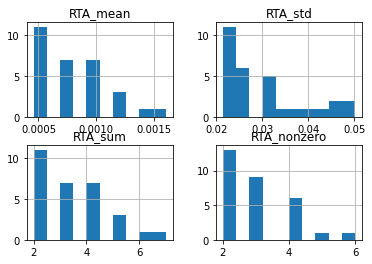

In [162]:
df_classes.loc[(df_classes.RTA_nonzero > 1) & (df_classes.RTA_nonzero <= 6)].hist();

In [163]:
import seaborn as sns

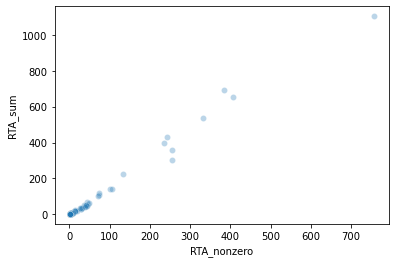

In [164]:
sns.scatterplot(data=df_classes, x="RTA_nonzero", y="RTA_sum", alpha=0.3);

In [165]:
df_classes.sort_values(by="RTA_sum", ascending=False)

,hex_bins,RTA_mean,RTA_std,RTA_sum,RTA_nonzero,pred_class_freq,pred_class_total
68,867a6e42fffffff,0.252689,0.699789,1104.0,757.0,4-high,4-high
63,867a6e407ffffff,0.158846,0.782969,694.0,383.0,4-high,4-high
90,867a6e557ffffff,0.149233,0.671690,652.0,407.0,4-high,4-high
84,867a6e50fffffff,0.122454,0.733095,535.0,333.0,4-high,4-high
65,867a6e417ffffff,0.098878,0.587040,432.0,243.0,4-high,4-high
...,...,...,...,...,...,...,...
28,867a45b77ffffff,0.000229,0.015129,1.0,1.0,1-lowest,1-lowest
26,867a45b67ffffff,0.000229,0.015129,1.0,1.0,1-lowest,1-lowest
60,867a6e18fffffff,0.000229,0.015129,1.0,1.0,1-lowest,1-lowest
22,867a45a8fffffff,0.000229,0.015129,1.0,1.0,1-lowest,1-lowest


In [166]:
#df_final.loc[df_final[]]

In [167]:
df_freq_outliers = df_classes.loc[df_classes["RTA_nonzero"] == 1]

In [168]:
list_freq_outliers = df_freq_outliers["hex_bins"].values
list(list_freq_outliers)

['867a45067ffffff',
 '867a45077ffffff',
 '867a4511fffffff',
 '867a4512fffffff',
 '867a45147ffffff',
 '867a4515fffffff',
 '867a45177ffffff',
 '867a45817ffffff',
 '867a4584fffffff',
 '867a4585fffffff',
 '867a458dfffffff',
 '867a458f7ffffff',
 '867a45a8fffffff',
 '867a45b0fffffff',
 '867a45b17ffffff',
 '867a45b67ffffff',
 '867a45b77ffffff',
 '867a6141fffffff',
 '867a614d7ffffff',
 '867a616b7ffffff',
 '867a6304fffffff',
 '867a632a7ffffff',
 '867a63307ffffff',
 '867a6331fffffff',
 '867a6360fffffff',
 '867a63667ffffff',
 '867a6396fffffff',
 '867a656c7ffffff',
 '867a65797ffffff',
 '867a6e18fffffff',
 '867a6e1b7ffffff',
 '867a6e4c7ffffff',
 '867a6e517ffffff',
 '867a6e59fffffff',
 '867a6e5a7ffffff',
 '867a6e5b7ffffff',
 '867a6e657ffffff',
 '867a6e737ffffff',
 '867a6e797ffffff',
 '867a6e79fffffff',
 '867a6e7b7ffffff',
 '867a6ecf7ffffff',
 '867a6ed47ffffff',
 '867a6ed97ffffff',
 '867a6eda7ffffff']

In [ ]:
list_segment_data = list(df_segments.h3_zone_6.unique())

In [ ]:
intersection_set = set.intersection(set(list_segment_data), set(list_freq))

In [ ]:
intersection_set

**Almost all hex bins for which we have segment data for seem to have a high or medium frequency and sum of accidents.**

In [ ]:
df_classes[df_classes["hex_bins"].isin(list_segment_data)].sort_values(by="RTA_sum", ascending=False)

In [ ]:
df_classes_cluster = df_final.groupby(["hex_bins", "cluster"])

In [ ]:
df_classes_cluster = df_classes_cluster.agg({'RTA': [np.mean, np.std, np.sum, np.count_nonzero]})

In [ ]:
df_classes_cluster = df_classes_cluster.reset_index()

In [ ]:
df_classes_cluster.columns

In [ ]:
df_classes_cluster.columns = ["hex_bins", "cluster", "RTA_mean", "RTA_std", "RTA_sum", "RTA_nonzero"]

In [ ]:
df_classes_cluster.head()

In [ ]:
df_classes_cluster.shape

In [ ]:
df_classes_cluster["pred_class_freq"] = ""

In [ ]:
df_classes_cluster.loc[df_classes_cluster["RTA_nonzero"] == 0, "pred_class_freq"] = "0-none"
df_classes_cluster.loc[df_classes_cluster["RTA_nonzero"] == 1, "pred_class_freq"] = "1-lowest"
df_classes_cluster.loc[(df_classes_cluster["RTA_nonzero"] > 1) & (df_classes_cluster["RTA_nonzero"] <= 10), "pred_class_freq"] = "2-low"
df_classes_cluster.loc[(df_classes_cluster["RTA_nonzero"] > 10) & (df_classes_cluster["RTA_nonzero"] <= 100), "pred_class_freq"] = "3-middle"
df_classes_cluster.loc[df_classes_cluster["RTA_nonzero"] > 100, "pred_class_freq"] = "4-high"

In [ ]:
df_classes_cluster.head()

In [ ]:
pd.crosstab(index=df_classes_cluster["cluster"], columns=df_classes_cluster["pred_class_freq"])

In [ ]:
df_classes_cluster.loc[df_classes_cluster["pred_class_freq"] == "4-high"]

### Only take those hex bins into the next data frame which do not have only 1 accident occurrence

In [ ]:
df_classes_no_outliers = df_classes_cluster.loc[~df_classes_cluster["hex_bins"].isin(list_freq)]

In [ ]:
df_classes_no_outliers.hex_bins.nunique()

In [ ]:
df_classes_no_outliers.head()

In [ ]:
filtered = [df_classes_no_outliers.groupby("hex_bins").RTA_sum.min() > 0]

In [ ]:
filtered

In [ ]:
for key, value in filtered:
    print(key, value)

In [ ]:
df_classes_cluster.groupby(["cluster", "pred_class_freq"]).RTA_sum.mean()

**Need to create a crosstab that has time_window as rows, hex_bin as columns and RTA as values.**

This can then be used to analyze the hex bins (and time window or time cluster combionations?) and sort them into groups for which the prediction can be done with different models.

In [ ]:
#Code

* Step 1: Divide hex bins into those that are "dangerous" and those that are "less dangerous" - these will be different models. Could be done accodring to frequencey and/or sum of accidents.
* Step 2: Normalize the RTA_sum and RTA_nonzero before that using the amounts of time windows in each time cluster (26-25-5 or such)

* Can we do this as a classification problem? - Outcome needs to be RTA (yes/no?) per hex bin then

Could we use all observations per time cluster (for example for all 26 time windows) to train the model and then predict inividually per time window since we have the (weather) data for that? We would then have 2 (or more) models for the different categories of hex-bins, where we suspect the location matters - and still a shitload (hopefully) of data if we also specify a model for each time cluster. This would bring us to currently 6 models. Although we have 500.000 obersvations, it has to be seen how these are allocated across the 6 different models for learning - especially since we are deleting all hex bins and the related observation where only one accident occurred.

### Predictions to try out for tomorrow

1. Use some sort of (upscaled) frequency as predictions - for each hex-bin/time-window combination there should be **ONE** value. This can then be used to cluster the time windows into larger groups (-or not?). Should try out letting the model generate 56 different placements as well perhaps?

2. ???